## Modeling - customer response will be predicted based on the profile and when the last customer purchases

In [ ]:
import numpy as np # linear algebra
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# PreProcessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,RobustScaler,MinMaxScaler,StandardScaler
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Splitting Data
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
# Resampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

# Modeling, Fitting and Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score,f1_score, precision_score, roc_auc_score, plot_roc_curve,recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn import metrics
from datetime import datetime
import datetime
# Boosting
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

#feature Selection
from sklearn.feature_selection import SelectPercentile, RFE

#saving
import pickle

In [ ]:
#load data
data = pd.read_csv('df_copy.csv')

In [ ]:
data.columns

Index(['ID', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Response', 'Complain', 'Country', 'Ages', 'Age_Group', 'Join_year',
       'Join_month', 'Join_weekday', 'Dependents', 'Total_Mnt',
       'Total_num_purchase', 'Total_accept', 'AOV'],
      dtype='object')

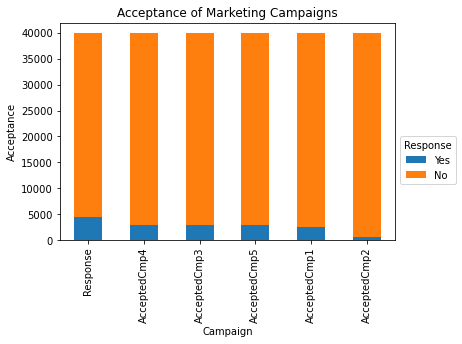

In [ ]:
#most successful campaign
campaign = data.loc[:,['Response','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']]

campaign = campaign.melt()
campaign = pd.crosstab(campaign["variable"], campaign["value"]).sort_values(0)

cols = list(campaign.columns)
a, b = cols.index(0), cols.index(1)
cols[b], cols[a] = cols[a], cols[b]
campaign = campaign[cols]
campaign.columns = "Yes","No"
campaign.plot.bar(stacked=True)
plt.title('Acceptance of Marketing Campaigns')
plt.xlabel('Campaign')
plt.ylabel('Acceptance')
plt.legend(title='Response',loc='upper left',bbox_to_anchor=(1, 0.5))
plt.show()

## Preprocessing

In [ ]:
# we will scale the numerical columns and encode the categorical columns 
scale = Pipeline([
        ('scaling', RobustScaler()),
])

transformer = ColumnTransformer([
    ('encoder',OneHotEncoder(handle_unknown='ignore'),['Education','Marital_Status']),
    ('binary',ce.BinaryEncoder(),['Country']),
    ('scale',RobustScaler(),['Ages','Recency'])
],remainder='passthrough')

In [ ]:
# predicting the customers response on based on their profile and their last purchase.
data=data.drop(['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth','Complain','Dt_Customer','ID','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','AcceptedCmp1','AcceptedCmp2','Age_Group', 'Join_year',
       'Join_month', 'Join_weekday', 'Dependents', 'Total_Mnt', 'Total_num_purchase', 'Total_accept', 'AOV'],axis=1)

In [ ]:
data.columns

Index(['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Recency', 'Response', 'Country', 'Ages'],
      dtype='object')

In [ ]:
data.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,Response,Country,Ages
0,PhD,Married,51518,2,1,4,0,GER,65
1,Graduation,Married,51518,1,0,11,0,US,39
2,PhD,Married,51518,1,0,17,0,AUS,50
3,Graduation,Single,51518,1,0,19,0,AUS,36
4,PhD,Married,51518,0,1,23,0,CA,61


In [ ]:
# Split the dataset into X , y
X=data.drop(['Response'],axis=1)
y=data['Response']

In [ ]:
print(X.shape, y.shape)

(39935, 8) (39935,)


In [ ]:
#check transform: scale the training data
transformer.fit_transform(data)

array([[0., 0., 0., ..., 2., 1., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 2., 1.]])

In [ ]:
X.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,Country,Ages
0,PhD,Married,51518,2,1,4,GER,65
1,Graduation,Married,51518,1,0,11,US,39
2,PhD,Married,51518,1,0,17,AUS,50
3,Graduation,Single,51518,1,0,19,AUS,36
4,PhD,Married,51518,0,1,23,CA,61


In [ ]:
# Data Splitting: Fit model to training data (70% of dataset) and Evaluate predictions on test data (30% of dataset) 

In [ ]:
# Split dataset into training set (70% of dataset) and test set (30% of dataset)
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.3,random_state=2020)

In [ ]:
print(X_train.shape, X_test.shape)

(27954, 8) (11981, 8)


## Model Prediction

In [ ]:
#Checking how balanced is our target Data
data['Response'].value_counts()/data.shape[0]*100

0    88.734193
1    11.265807
Name: Response, dtype: float64

In [ ]:
# Model selection
lr = LogisticRegression()
tree = DecisionTreeClassifier(random_state = 2020)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state = 2020)

In [ ]:
# creating pipeline
lr_pipe = Pipeline([
    ('transform',transformer),
    ('lr',lr)
])

tree_pipe= Pipeline([
    ('transform',transformer),
    ('tree',tree)
])

knn_pipe =Pipeline([
    ('transform',transformer),
    ('knn',knn)
])

rf_pipe = Pipeline([
    ('transform',transformer),
    ('rf',rf)
])

In [ ]:
def model_evaluation(model, metric):
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(model, X_train, y_train, cv = skfold, scoring = metric)
    return model_cv

lr_pipe_cv = model_evaluation(lr_pipe, 'precision')
tree_pipe_cv = model_evaluation(tree_pipe, 'precision')
knn_pipe_cv = model_evaluation(knn_pipe, 'precision')
rf_pipe_cv = model_evaluation(rf_pipe, 'precision')

for model in [lr_pipe,tree_pipe, knn_pipe,rf_pipe]:
    model.fit(X_train, y_train)
    
score_mean = [lr_pipe_cv.mean(),tree_pipe_cv.mean(),knn_pipe_cv.mean(),rf_pipe_cv.mean()]
score_std = [lr_pipe_cv.std(),tree_pipe_cv.std(),knn_pipe_cv.std(),rf_pipe_cv.std()]
score_precision_score = [precision_score(y_test, lr_pipe.predict(X_test)),
                         precision_score(y_test, tree_pipe.predict(X_test)),
            precision_score(y_test, knn_pipe.predict(X_test)),
            precision_score(y_test, rf_pipe.predict(X_test))]
score_f1_score = [f1_score(y_test, lr_pipe.predict(X_test)),f1_score(y_test, tree_pipe.predict(X_test)),
                        f1_score(y_test, knn_pipe.predict(X_test)),f1_score(y_test, rf_pipe.predict(X_test))]
method_name = ['Logistic Regression','Decision Tree Classifier','KNN Classifier', 'Random Forest Classifier']
cv_result = pd.DataFrame({
    'method': method_name,
    'mean score': score_mean,
    'std score': score_std,
    'precision score': score_precision_score,
    'f1 score': score_f1_score,
})
cv_result

,method,mean score,std score,precision score,f1 score
0,Logistic Regression,0.000000,0.000000,0.000000,0.000000
1,Decision Tree Classifier,0.956315,0.013380,0.968727,0.966209
2,KNN Classifier,0.972901,0.006715,0.984906,0.975701
3,Random Forest Classifier,0.982673,0.007802,0.986228,0.970267


In [ ]:
# confusion matrix KNN
knn_pipe.fit(X_train, y_train)
ypred=knn_pipe.predict(X_test)

print(classification_report(y_test,ypred))
print(metrics.confusion_matrix(y_test,ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10631
           1       0.98      0.97      0.98      1350

    accuracy                           0.99     11981
   macro avg       0.99      0.98      0.99     11981
weighted avg       0.99      0.99      0.99     11981

[[10611    20]
 [   45  1305]]


In [ ]:
# confusion matrix RANDOM forest classifier
rf_pipe.fit(X_train, y_train)
ypred=rf_pipe.predict(X_test)

print(classification_report(y_test,ypred))
print(metrics.confusion_matrix(y_test,ypred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     10631
           1       0.99      0.95      0.97      1350

    accuracy                           0.99     11981
   macro avg       0.99      0.98      0.98     11981
weighted avg       0.99      0.99      0.99     11981

[[10613    18]
 [   61  1289]]


In [ ]:
rus = RandomUnderSampler(random_state = 2020)
X_under, y_under = rus.fit_resample(X_train, y_train) 

In [ ]:
lr_pipe_under = Pipeline([
    ('transformer', transformer),
    ('rus', rus),
    ('lr', lr)
])

tree_pipe_under = Pipeline([
    ('transformer', transformer),
    ('rus', rus),
    ('tree', tree)
])

knn_pipe_under = Pipeline([
    ('transformer', transformer),
    ('rus', rus),
    ('knn', knn)
])
rf_pipe_under = Pipeline([
    ('transformer', transformer),
    ('rus', rus),
    ('rf', rf)
])

In [ ]:
def model_evaluation(model, metric):
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(model, X_train, y_train, cv = skfold, scoring = metric) 
    return model_cv

lr_under_cv = model_evaluation(lr_pipe_under, 'precision') 
tree_under_cv = model_evaluation(tree_pipe_under, 'precision')
knn_under_cv = model_evaluation(knn_pipe_under, 'precision')
rf_under_cv = model_evaluation(rf_pipe_under, 'precision')

for model in [lr_pipe_under, tree_pipe_under, knn_pipe_under, rf_pipe_under]:
    model.fit(X_train, y_train)

score_mean = [lr_under_cv.mean(), tree_under_cv.mean(), knn_under_cv.mean(),
              rf_under_cv.mean()]
score_std = [lr_under_cv.std(), tree_under_cv.std(), knn_under_cv.std(),
             rf_under_cv.std()]
score_precision_score = [precision_score(y_test, lr_pipe_under.predict(X_test)),
            precision_score(y_test, tree_pipe_under.predict(X_test)), 
            precision_score(y_test, knn_pipe_under.predict(X_test)), 
            precision_score(y_test, rf_pipe_under.predict(X_test))]
score_f1_score = [f1_score(y_test, lr_pipe_under.predict(X_test)),f1_score(y_test, tree_pipe_under.predict(X_test)),
                        f1_score(y_test, knn_pipe_under.predict(X_test)),f1_score(y_test, rf_pipe_under.predict(X_test))]
method_name = ['Logistic Regression UnderSampling', 'Decision Tree Classifier UnderSampling',
              'KNN Classifier UnderSampling', 'Random Forest Classifier UnderSampling']
under_result = pd.DataFrame({
    'method': method_name,
    'mean score': score_mean,
    'std score': score_std,
    'precision score': score_precision_score,
    'f1 score': score_f1_score,
})
under_result

,method,mean score,std score,precision score,f1 score
0,Logistic Regression UnderSampling,0.112649,0.000063,0.112678,0.202535
1,Decision Tree Classifier UnderSampling,0.820575,0.008652,0.843212,0.906475
2,KNN Classifier UnderSampling,0.543427,0.007016,0.619361,0.757907
3,Random Forest Classifier UnderSampling,0.884212,0.013374,0.898700,0.934187


In [ ]:
ros = RandomOverSampler(random_state = 2020)
X_over, y_over = ros.fit_resample(X_train, y_train)

In [ ]:
lr_pipe_over = Pipeline([
    ('transformer', transformer),
    ('ros', ros), 
    ('lr', lr)
])

tree_pipe_over = Pipeline([
    ('transformer', transformer),
    ('ros', ros), 
    ('tree', tree)
])

knn_pipe_over = Pipeline([
    ('transformer', transformer),
    ('ros', ros), 
    ('knn', knn)
])

rf_pipe_over = Pipeline([
    ('transformer', transformer),
    ('ros', ros),
    ('rf', rf)
])

In [ ]:
def model_evaluation(model, metric):
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(model, X_train, y_train, cv = skfold, scoring = metric)
    return model_cv

lr_over_cv = model_evaluation(lr_pipe_over, 'precision') 
tree_over_cv = model_evaluation(tree_pipe_over, 'precision')
knn_over_cv = model_evaluation(knn_pipe_over, 'precision')
rf_over_cv = model_evaluation(rf_pipe_over, 'precision')

for model in [lr_pipe_over, tree_pipe_over, knn_pipe_over, rf_pipe_over]:
    model.fit(X_train, y_train)

score_mean = [lr_over_cv.mean(), tree_over_cv.mean(), knn_over_cv.mean(),
               rf_over_cv.mean()]
score_std = [lr_over_cv.std(), tree_over_cv.std(), knn_over_cv.std(),
             rf_over_cv.std()]
score_precision_score = [precision_score(y_test, lr_pipe_over.predict(X_test)),
            precision_score(y_test, tree_pipe_over.predict(X_test)), 
            precision_score(y_test, knn_pipe_over.predict(X_test)), 
            precision_score(y_test, rf_pipe_over.predict(X_test))]
score_f1_score = [f1_score(y_test, lr_pipe_over.predict(X_test)),f1_score(y_test, tree_pipe_over.predict(X_test)),
                        f1_score(y_test, knn_pipe_over.predict(X_test)),f1_score(y_test, rf_pipe_over.predict(X_test))]
method_name = ['Logistic Regression OverSampling', 'Decision Tree Classifier OverSampling',
              'KNN Classifier OverSampling', 'Random Forest Classifier OverSampling']
over_summary = pd.DataFrame({
    'method': method_name,
    'mean score': score_mean,
    'std score': score_std,
    'precision score': score_precision_score,
    'f1 score': score_f1_score,
})
over_summary

,method,mean score,std score,precision score,f1 score
0,Logistic Regression OverSampling,0.112649,0.000063,0.112678,0.202535
1,Decision Tree Classifier OverSampling,0.951883,0.007531,0.962610,0.967576
2,KNN Classifier OverSampling,0.956961,0.006760,0.968452,0.973093
3,Random Forest Classifier OverSampling,0.965865,0.005242,0.978261,0.972429


In [ ]:
nm = NearMiss(version = 1)

In [ ]:
lr_pipe_nm = Pipeline([
    ('transformer', transformer),
    ('nm', nm),
    ('lr', lr)
])

tree_pipe_nm = Pipeline([
    ('transformer', transformer),
    ('nm', nm),
    ('tree', tree)
])

knn_pipe_nm = Pipeline([
    ('transformer', transformer),
    ('nm', nm),
    ('knn', knn)
])

rf_pipe_nm = Pipeline([
    ('transformer', transformer),
    ('nm', nm),
    ('rf', rf)
])

In [ ]:
def model_evaluation(model, metric):
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(model, X_train, y_train, cv = skfold, scoring = metric)
    return model_cv

lr_nm_cv = model_evaluation(lr_pipe_nm, 'precision') 
tree_nm_cv = model_evaluation(tree_pipe_nm, 'precision')
knn_nm_cv = model_evaluation(knn_pipe_nm, 'precision')
rf_nm_cv = model_evaluation(rf_pipe_nm, 'precision')

for model in [lr_pipe_nm, tree_pipe_nm, knn_pipe_nm, rf_pipe_nm]:
    model.fit(X_train, y_train)
    
score_mean = [lr_nm_cv.mean(), tree_nm_cv.mean(), knn_nm_cv.mean(),
              rf_nm_cv.mean()]
score_std = [lr_nm_cv.std(), tree_nm_cv.std(), knn_nm_cv.std(),
             rf_nm_cv.std()]
score_precision_score = [precision_score(y_test, lr_pipe_nm.predict(X_test)),
                         precision_score(y_test, tree_pipe_nm.predict(X_test)), 
            precision_score(y_test, knn_pipe_nm.predict(X_test)), 
            precision_score(y_test, rf_pipe_nm.predict(X_test))]
score_f1_score = [f1_score(y_test, lr_pipe_nm.predict(X_test)),f1_score(y_test, tree_pipe_nm.predict(X_test)),
                        f1_score(y_test, knn_pipe_nm.predict(X_test)),f1_score(y_test, rf_pipe_nm.predict(X_test))]
method_name = ['Logistic Regression NearMiss', 'Decision Tree Classifier NearMiss',
              'KNN Classifier NearMiss', 'Random Forest Classifier NearMiss']
nm_summary = pd.DataFrame({
    'method': method_name,
    'mean score': score_mean,
    'std score': score_std,
    'precision score': score_precision_score,
    'f1 score': score_f1_score,
})
nm_summary

,method,mean score,std score,precision score,f1 score
0,Logistic Regression NearMiss,0.152040,0.048209,0.112678,0.202535
1,Decision Tree Classifier NearMiss,0.252399,0.006228,0.251047,0.399455
2,KNN Classifier NearMiss,0.191867,0.004097,0.190662,0.319061
3,Random Forest Classifier NearMiss,0.275557,0.005598,0.283871,0.440000


In [ ]:
#Summary Balancing Dataset
resume_balancing = pd.concat([under_result,over_summary,nm_summary], axis=0)
resume_balancing

,method,mean score,std score,precision score,f1 score
0,Logistic Regression UnderSampling,0.112649,0.000063,0.112678,0.202535
1,Decision Tree Classifier UnderSampling,0.820575,0.008652,0.843212,0.906475
2,KNN Classifier UnderSampling,0.543427,0.007016,0.619361,0.757907
3,Random Forest Classifier UnderSampling,0.884212,0.013374,0.898700,0.934187
0,Logistic Regression OverSampling,0.112649,0.000063,0.112678,0.202535
1,Decision Tree Classifier OverSampling,0.951883,0.007531,0.962610,0.967576
2,KNN Classifier OverSampling,0.956961,0.006760,0.968452,0.973093
3,Random Forest Classifier OverSampling,0.965865,0.005242,0.978261,0.972429
0,Logistic Regression NearMiss,0.152040,0.048209,0.112678,0.202535
1,Decision Tree Classifier NearMiss,0.252399,0.006228,0.251047,0.399455


In [ ]:
adaboost = AdaBoostClassifier(
            tree,
            n_estimators = 50,
            learning_rate = 0.1,
            random_state = 2020)

pipe_ada = Pipeline([
    ('transformer', transformer),
    ('adaboost', adaboost)
])

gradboost = GradientBoostingClassifier(
            n_estimators = 50,
            learning_rate = 0.1,
            max_depth = 3,
            random_state = 2020)

pipe_grad = Pipeline([
    ('transformer', transformer),
    ('gradboost', gradboost)
])

XGBOOST = XGBClassifier(
            n_estimators = 50,
            learning_rate = 0.1,
            max_depth = 3,
            random_state = 2020)

pipe_XGB = Pipeline([
    ('transformer', transformer),
    ('XGBOOST', XGBOOST)
])

In [ ]:
def model_evaluation(model, metric):
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(model, X_train, y_train, cv = skfold, scoring = metric, n_jobs = -1)
    return model_cv

pipe_ada_cv = model_evaluation(pipe_ada, 'precision')
pipe_grad_cv = model_evaluation(pipe_grad, 'precision')
pipe_XGB_cv = model_evaluation(pipe_XGB, 'precision')

for model in [pipe_ada, pipe_grad, pipe_XGB]:
    model.fit(X_train, y_train)
    
score_mean = [pipe_ada_cv.mean(), pipe_grad_cv.mean(), pipe_XGB_cv.mean()]
score_std = [pipe_ada_cv.std(), pipe_grad_cv.std(), pipe_XGB_cv.std()]
score_precision_score = [precision_score(y_test, pipe_ada.predict(X_test)),
                         precision_score(y_test, pipe_grad.predict(X_test)), 
            precision_score(y_test, pipe_XGB.predict(X_test))]
score_f1_score = [f1_score(y_test, pipe_ada.predict(X_test)),f1_score(y_test, pipe_grad.predict(X_test)),
                           f1_score(y_test, pipe_grad.predict(X_test))]
method_name = ['Ada Boost Classifier', 'Gradient Boost Classifier',
              'XGB Classifier']
boost_summary = pd.DataFrame({
    'method': method_name,
    'mean score': score_mean,
    'std score': score_std,
    'precision score': score_precision_score,
    'f1 score': score_f1_score,
})
boost_summary

[18:08:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,method,mean score,std score,precision score,f1 score
0,Ada Boost Classifier,0.972921,0.008368,0.981777,0.969629
1,Gradient Boost Classifier,0.876815,0.026270,0.899749,0.410520
2,XGB Classifier,0.884991,0.020243,0.866667,0.410520


In [ ]:
resume_model = pd.concat([cv_result,boost_summary], axis=0)
resume_model

,method,mean score,std score,precision score,f1 score
0,Logistic Regression,0.000000,0.000000,0.000000,0.000000
1,Decision Tree Classifier,0.956315,0.013380,0.968727,0.966209
2,KNN Classifier,0.972901,0.006715,0.984906,0.975701
3,Random Forest Classifier,0.982673,0.007802,0.986228,0.970267
0,Ada Boost Classifier,0.972921,0.008368,0.981777,0.969629
1,Gradient Boost Classifier,0.876815,0.026270,0.899749,0.410520
2,XGB Classifier,0.884991,0.020243,0.866667,0.410520


In [ ]:
# KNN Classifier score 

In [ ]:
knn_pipe.fit(X_train, y_train)
y_pred_estimator = knn_pipe.predict(X_test)
precision_estimator = precision_score(y_test, knn_pipe.predict(X_test))
f1_estimator = f1_score(y_test, y_pred_estimator)


method_name = ['KNN Classifier_Test']
best_summary = pd.DataFrame({
    'method': method_name,
    'Precision_score': precision_estimator,
    'F1_score': f1_estimator
})
best_summary

,method,Precision_score,F1_score
0,KNN Classifier_Test,0.984906,0.975701


In [ ]:
train_pred = knn_pipe.predict(X_train) #prediction on trained data
train_precision_estimator = precision_score(y_train, train_pred)
train_f1_estimator = f1_score(y_train, train_pred)


method_name = ['KNN Classifier_Train']
train_best_summary = pd.DataFrame({
    'method': method_name,
    'Precision_score': train_precision_estimator,
    'F1_score': train_f1_estimator
})
train_best_summary

,method,Precision_score,F1_score
0,KNN Classifier_Train,0.972527,0.96396


In [ ]:
rf_pipe.fit(X_train, y_train)
rf_y_pred_estimator = rf_pipe.predict(X_test)
precision_estimator = precision_score(y_test,rf_y_pred_estimator)
f1_estimator = f1_score(y_test, rf_y_pred_estimator, average='binary')




#score_list = [precision_estimator,f1_estimator, train_precision_estimator ,train_f1_estimator]
method_name = ['Random Forest Classifier_Test']
rf_best_summary = pd.DataFrame({
    'method': method_name,
    'precision_score': precision_estimator,
    'F1_score': f1_estimator
})
rf_best_summary

,method,precision_score,F1_score
0,Random Forest Classifier_Test,0.986228,0.970267


In [ ]:
rf_train_pred = knn_pipe.predict(X_train) #prediction on trained data
train_precision_estimator = precision_score(y_train,rf_train_pred)
train_f1_estimator = f1_score(y_train, rf_train_pred)

method_name = ['Random Forest Classifier_Train']
rf_train_best_summary = pd.DataFrame({
    'method': method_name,
    'precision_score': train_precision_estimator,
    'F1_score': train_f1_estimator
})
rf_train_best_summary


,method,precision_score,F1_score
0,Random Forest Classifier_Train,0.972527,0.96396


In [ ]:
pipe_XGB.fit(X_train, y_train)
XGB_y_pred_estimator = pipe_XGB.predict(X_test)
precision_estimator = precision_score(y_test,XGB_y_pred_estimator)
f1_estimator = f1_score(y_test, XGB_y_pred_estimator, average='binary')




#score_list = [precision_estimator,f1_estimator, train_precision_estimator ,train_f1_estimator]
method_name = ['XGB Classifier_Test']
XGB_best_summary = pd.DataFrame({
    'method': method_name,
    'precision_score': precision_estimator,
    'F1_score': f1_estimator
})
XGB_best_summary

[18:38:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,method,precision_score,F1_score
0,XGB Classifier_Test,0.866667,0.352802


In [ ]:
XGB_train_pred = pipe_XGB.predict(X_train) #prediction on trained data
train_precision_estimator = precision_score(y_train,XGB_train_pred)
train_f1_estimator = f1_score(y_train, XGB_train_pred)

method_name = ['XGB Classifier_Train']
XGB_train_best_summary = pd.DataFrame({
    'method': method_name,
    'precision_score': train_precision_estimator,
    'F1_score': train_f1_estimator
})
XGB_train_best_summary

,method,precision_score,F1_score
0,XGB Classifier_Train,0.887517,0.333677


In [ ]:
train_pred = knn_pipe.predict(X_train)  #prediction on trained data
f1_score(y_train, train_pred)

0.9639596347909658

precision score without tunning is better than after tunning, so the model will be choose is Random Forest Classifier without tuning.

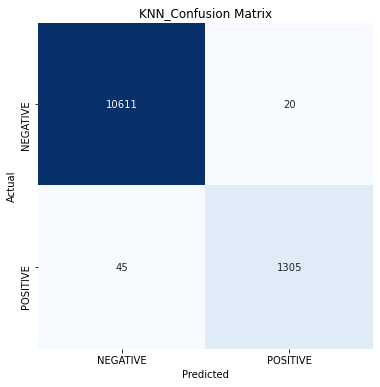

KNN_Confusion Matrix:
----------------------
 [[10611    20]
 [   45  1305]]

KNN_Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00     10631
    POSITIVE       0.98      0.97      0.98      1350

    accuracy                           0.99     11981
   macro avg       0.99      0.98      0.99     11981
weighted avg       0.99      0.99      0.99     11981



In [ ]:
# classification report and plotting confusion matrix
knn_cm = confusion_matrix(y_test,y_pred_estimator)
knn_clr = classification_report(y_test,y_pred_estimator, target_names=["NEGATIVE", "POSITIVE"])

plt.figure(figsize=(6, 6))
sns.heatmap(knn_cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNN_Confusion Matrix")
plt.show()

print("KNN_Confusion Matrix:\n----------------------\n", knn_cm)
print()
print("KNN_Classification Report:\n----------------------\n", knn_clr)

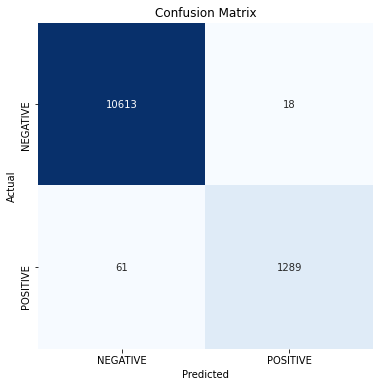

Confusion Matrix:
----------------------
 [[10613    18]
 [   61  1289]]

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.99      1.00      1.00     10631
    POSITIVE       0.99      0.95      0.97      1350

    accuracy                           0.99     11981
   macro avg       0.99      0.98      0.98     11981
weighted avg       0.99      0.99      0.99     11981



In [ ]:
# classification report and plotting confusion matrix
rf_cm = confusion_matrix(y_test,rf_y_pred_estimator)
rf_clr = classification_report(y_test,rf_y_pred_estimator, target_names=["NEGATIVE", "POSITIVE"])

plt.figure(figsize=(6, 6))
sns.heatmap(rf_cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("RF_Confusion Matrix")
plt.show()

print("RF_Confusion Matrix:\n----------------------\n", rf_cm)
print()
print("RF_Classification Report:\n----------------------\n", rf_clr)

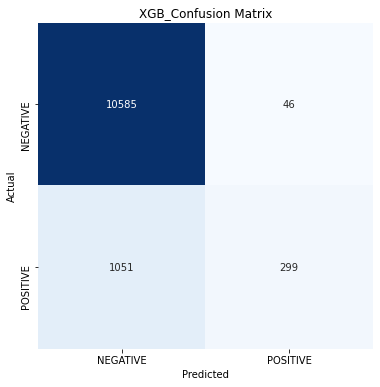

XGB_Confusion Matrix:
----------------------
 [[10585    46]
 [ 1051   299]]

XGB_Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.91      1.00      0.95     10631
    POSITIVE       0.87      0.22      0.35      1350

    accuracy                           0.91     11981
   macro avg       0.89      0.61      0.65     11981
weighted avg       0.90      0.91      0.88     11981



In [ ]:
# classification report and plotting confusion matrix
XGB_cm = confusion_matrix(y_test,XGB_y_pred_estimator)
XGB_clr = classification_report(y_test,XGB_y_pred_estimator, target_names=["NEGATIVE", "POSITIVE"])

plt.figure(figsize=(6, 6))
sns.heatmap(XGB_cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGB_Confusion Matrix")
plt.show()

print("XGB_Confusion Matrix:\n----------------------\n", XGB_cm)
print()
print("XGB_Classification Report:\n----------------------\n", XGB_clr)

In [ ]:
TP = knn_cm[1,1] # true positive 
TN = knn_cm[0,0] # true negatives
FP = knn_cm[0,1] # false positives
FN = knn_cm[1,0] # false negatives
FP

20

In [ ]:
# Let's see the sensitivity of our Random Forest Classifier model
print('Sensivity :')
TP / float(TP+FN)

Sensivity :


0.9666666666666667

In [ ]:
# Let us calculate specificity
print('Specificity :')
TN / float(TN+FP)

Specificity :


0.9981187094346722

In [ ]:
# Overall accuracy
ACC = float(TP+TN)/float(TP+FP+FN+TN)
ACC

0.9945747433436274

Export the tested model to a pickle file

In [ ]:
# use pickle to store the model onto our disk.
filename = 'response_model.p'
#model_pickle = pickle.dump( grid_search, open( "loan_model.p", "wb" ) )
pickle.dump(knn_pipe, open(filename, 'wb'))

In [ ]:
#When we load the pickle back:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)


0.9945747433436274


In [ ]:
# use our trained model to predict.

# calculate the predictions for each class
X_predict = knn_pipe.predict(X_test)

# create the solution dataframe
Result = pd.DataFrame(data=X_predict,  columns=['Response'])
Result = Result['Response'].map({0:'N', 1:'Y'})
Result

0        N
1        Y
2        N
3        N
4        N
        ..
11976    N
11977    N
11978    N
11979    N
11980    N
Name: Response, Length: 11981, dtype: object

In [ ]:
# save the solution as an csv file
Result.to_csv('Solution1.csv', header=True)

Export solution information to a file that will be useful later on in our prediction application

In [ ]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

In [ ]:
df = pd.read_csv('df_copy.csv')

In [ ]:
y_test_pred = knn_pipe.predict(df)

In [ ]:
df['Predict_Response'] = y_test_pred
df_final = df[['ID', 'Response', 'Predict_Response']]

In [ ]:
df_final['Response'] = df_final['Response'].map({0:'N', 1:'Y'})

In [ ]:
df_final['Predict_Response'] = df_final['Predict_Response'].map({0:'N', 1:'Y'})

In [ ]:
df_final.to_csv('Solution_2.csv', index=False)

In [ ]:
df_final.head()

,ID,Response,Predict_Response
0,8996,N,N
1,1994,N,N
2,3769,N,N
3,5255,N,N
4,8268,N,N


In [ ]:
df_final.shape

(39935, 3)